In [1]:
from mimic.utilities.utilities import *

from mimic.model_infer import *
from mimic.model_simulate import *
import random
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Comparison of ridge vs lasso regression

### Five species, single time course. 
Note that perturbation not currently implemented in multi penalty lasso

Model parameters:
Model: gLV
num_species: 5
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.   -0.03  0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.02  0.    0.    0.   -0.2 ]]
epsilon: [[0.0], [-1.0], [0.0], [-1.0], [0.0]]
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05 ,  0.   , -0.025,  0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.05 ,  0.   ],
       [ 0.   ,  0.   , -0.15 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.01 ,  0.   ],
       [ 0.02 ,  0.   ,  0.   ,  0.   , -0.2  ]]), 'epsilon': [[0.0], [-1.0], [0.0], [-1.0], [0.0]]}
n: 245, p: 30


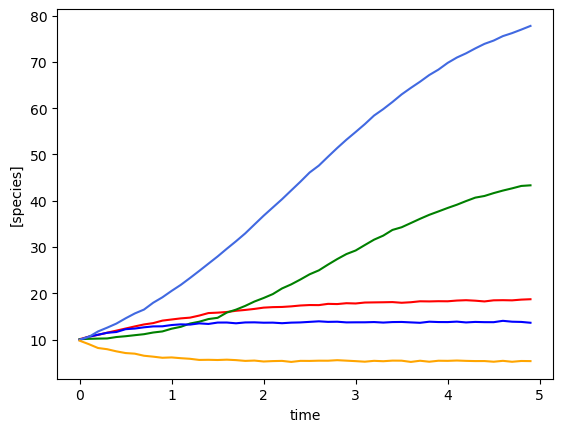

In [5]:
set_all_seeds(1234)

# SETUP MODEL
# establish size of model
num_species = 5

# construct interaction matrix
# TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

epsilon = [[0.],
           [-1.],
           [0.],
           [-1.],
           [0.]]

# instantiate simulator
simulator = sim_gLV(num_species=num_species,
                    M=M,
                    mu=mu,
                    epsilon=epsilon)
simulator.print_parameters()

# PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)

times = np.arange(0, 5, 0.1)
yobs, y0, mu, M, _ = simulator.simulate(times=times, init_species=init_species)

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)

# plot simulation
plot_gLV(yobs, times)

# linearise
X, F = linearize_time_course_16S(yobs, times)
print(f"n: {num_species * F.shape[0]}, p: {num_species + num_species ** 2}")

### Perform ridge regression

minimum found: a0/a1/error: 0.06951927961775606 0.0003359818286283781 0.10405332708603166
unconstrained error        : 0.10508759597522435
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': [3.495273836283104, 1.3752426789124002, 3.7746061360032854, 0.2759617002138839, 12.155875671033527], 'M': [[-0.2860433235152442, -0.1178228593230699, 0.07031626490066856, 0.080489888152254, -0.049681887136713954], [-0.1471772462311094, -0.1776324486328349, 0.08720999680920727, 0.10206563770864818, 0.005410058398354067], [0.24336282352099659, 0.10722167746159528, -0.4722415085278797, -0.0740124667648363, -0.1303213389985629], [0.08799281258887959, 0.059347563956976046, -0.03958183765368517, -0.04866249046833104, -0.014063858132203677], [-0.12368556630732286, -0.07890797235728542, -0.5039787404198037, 0.05371379775258234, -0.6769108529768957]], 'epsilon': array([], shape=(5, 0), dtype=float64)}
mu_hat/mu:
[ 3.49527384  1.37524268  3.77460614  0.2759617  12.15587567]
[1.2785384

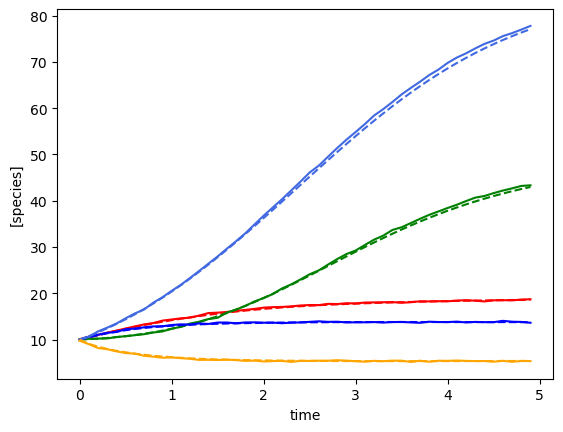

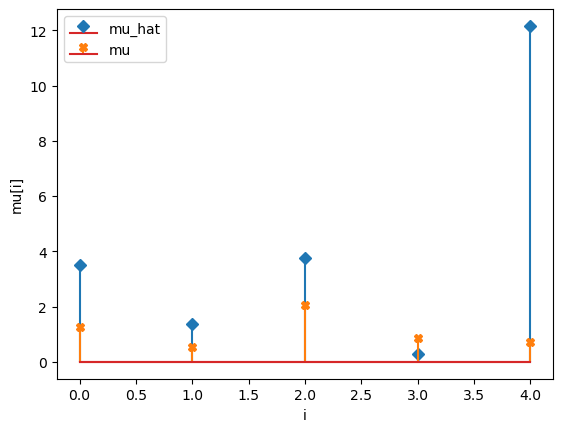

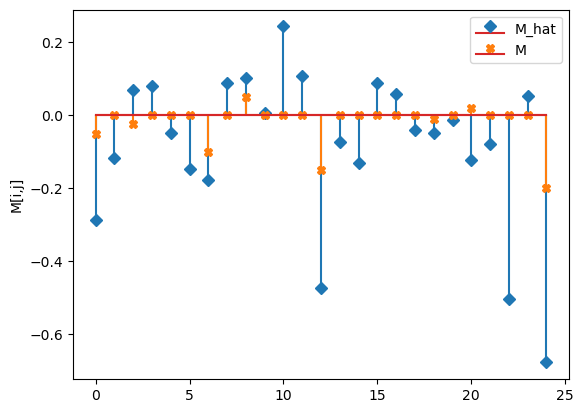

In [6]:
# get the best lambda/alpha values on a grid via cross validation
a0, a1 = fit_alpha_Ridge1(X, F, num_species=num_species, n_a0=20, n_a1=20)

# do final fit
mu_h, M_h = do_final_fit_Ridge1(X, F, num_species, a0=a0, a1=a1)

predictor = sim_gLV(num_species=num_species,
                    M=M_h,
                    mu=mu_h)

yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=init_species)

# PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gLV(yobs, yobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu, mu_h), M=(M, M_h))

### Fit same data with the multi-penalty lasso

minimum found: a/error: [2.78255940e-07 4.64158883e-06] 0.10638224667375122
mu_hat/mu:
[ 4.49564272  1.73939019  4.75586439  0.09963634 16.27427325]
[1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]

M_hat/M:
[[-0.34 -0.15  0.07  0.1  -0.08]
 [-0.18 -0.2   0.1   0.12 -0.  ]
 [ 0.27  0.12 -0.55 -0.08 -0.18]
 [ 0.11  0.07 -0.05 -0.06 -0.01]
 [-0.21 -0.13 -0.65  0.09 -0.84]]

 [[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': [4.495642720848084, 1.739390185287246, 4.755864394978705, 0.09963634038666683, 16.274273248244413], 'M': [[-0.3446720335391859, -0.14979599475823313, 0.06743261767426544, 0.10201564369096486, -0.07831787920886549], [-0.18246588542368164, -0.19707724984556318, 0.0983591466211684, 0.11510828050290738, -0.00033206547262519526], [0.2698212258221355, 0

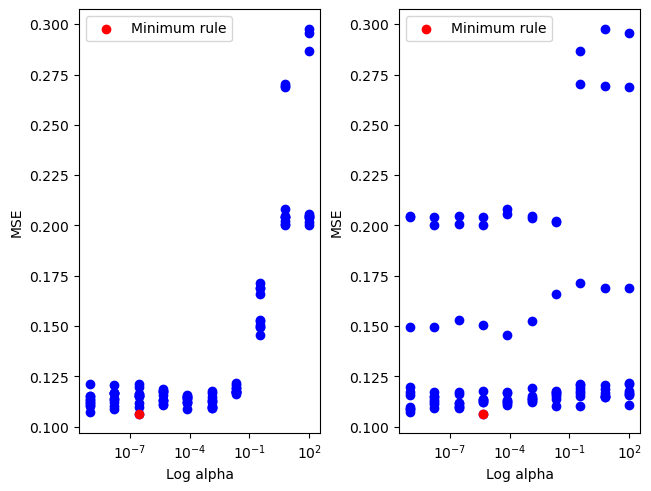

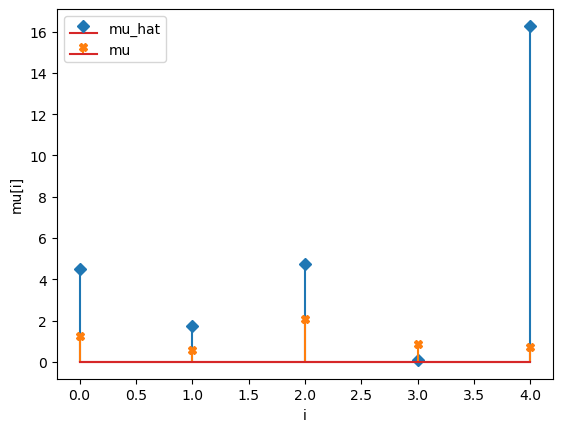

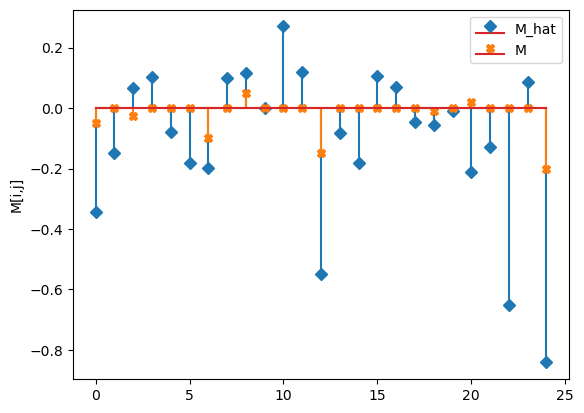

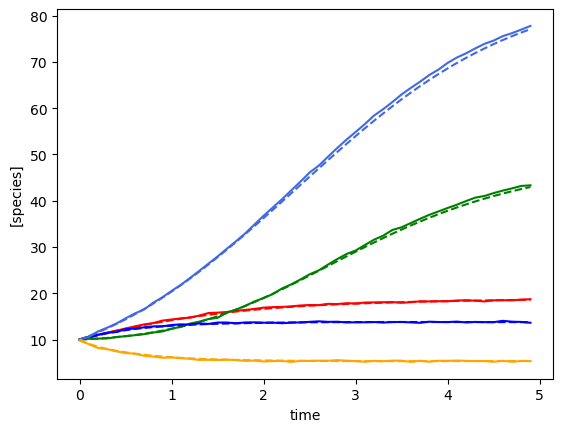

In [7]:
# F = dlnX/dt
DlnX = np.diff(np.log(yobs), axis=0)
Dt = np.tile(np.diff(times), (num_species, 1))
F = np.divide(DlnX, np.transpose(Dt))

# X matrix: stacked observed counts
mX = np.vstack([np.transpose(yobs), np.ones(len(times))])
tX = np.transpose(mX[:, :-1])

alphas = fit_alpha_MPLasso(tX, F, 10)

alpha = np.append(np.ones(num_species)*alphas[0], alphas[1])
model = MultiPenaltyLasso(alpha=alpha)
model.fit(tX, F)

mu_h = [model.coef_[i][-1] for i in range(0, num_species)]
M_h = [model.coef_[i][:num_species].tolist() for i in range(0, num_species)]

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu, mu_h), M=(M, M_h))

rho = 100

# get prediction
predictor = sim_gLV(num_species=num_species,
                    M=M_h,
                    mu=mu_h)

yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=init_species)

# plot comparison of simulated and predicted timeseries
plot_fit_gLV(yobs, yobs_h, times)